In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

from torchvision.models import resnet50, ResNet50_Weights

## Load a pretrained Resnet Model

In [2]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).cuda()
model.eval()

for param in model.parameters():
    param.requires_grad = False

del resnet_model

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


## Prepare data transformations

In [3]:
transform = ResNet50_Weights.DEFAULT.transforms()

## Visualize embeddings

In [5]:
import urllib.request
import tarfile

# Download the file if it does not exist
if not Path('transistor.tar.xz').exists():
    url = "https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938166-1629953277/transistor.tar.xz"
    urllib.request.urlretrieve(url, 'transistor.tar.xz')

with tarfile.open('transistor.tar.xz') as f:
    f.extractall('.')

In [8]:
class_labels = []
y_true = []
resnet_features = []

for classes in ['bent_lead','cut_lead','damaged_case','misplaced', 'good']:
    folder_path = Path(r'/content/transistor/test/{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = model(test_image)
            resnet_features.append(features.squeeze().cpu().detach().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1)

resnet_features = np.array(resnet_features)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

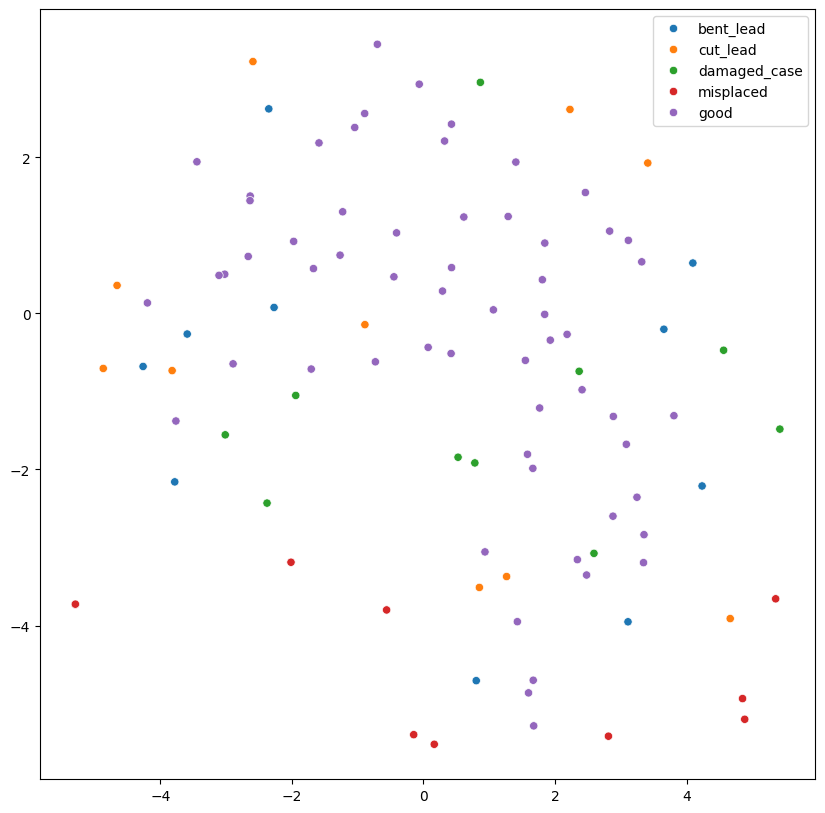

In [9]:
from sklearn.manifold import TSNE
# Perform t-SNE to reduce dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
resnet_features_2d = tsne.fit_transform(resnet_features)

plt.figure(figsize=(10,10))
sns.scatterplot(x=resnet_features_2d[:,0],y=resnet_features_2d[:,1],hue=class_labels)
plt.show()

## Create a memory bank

In [11]:
memory_bank =[]

folder_path = Path('/content/transistor/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):

    with torch.no_grad():
        data = transform(Image.open(pth)).cuda().unsqueeze(0)
        features = model(data)
        memory_bank.append(features.squeeze().cpu().detach())

memory_bank = torch.stack(memory_bank).cuda()

0it [00:00, ?it/s]

## Plot the std of columns in the memory bank

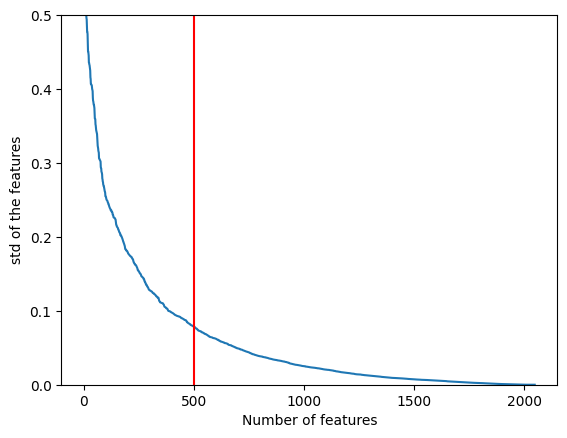

In [13]:
values,indices = torch.sort(memory_bank.std(dim=0))

plt.plot(values.cpu().numpy()[::-1])
plt.vlines(x=500,ymin=0,ymax=0.5,colors='red')
plt.ylim([0,0.5])
plt.ylabel("std of the features")
plt.xlabel("Number of features")
plt.show()

In [14]:
values,indices = torch.sort(memory_bank.std(dim=0))
selected_indices = indices[-500:]
memory_bank = memory_bank[:,selected_indices]
memory_bank.shape

torch.Size([213, 500])

## For OK images [K nearsest neighbours]

In [16]:
y_score=[]

k=50

folder_path = Path('/content/transistor/train/good')

for pth in tqdm(folder_path.iterdir(),leave=False):
    data = transform(Image.open(pth)).cuda().unsqueeze(0)
    with torch.no_grad():
        features = model(data).squeeze()
    dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))# Calculating the pair-wise distance between the sample and memory bank
    dist = dist[:k].mean()# K nearsest neighbours
    y_score.append(dist.cpu().numpy())

0it [00:00, ?it/s]

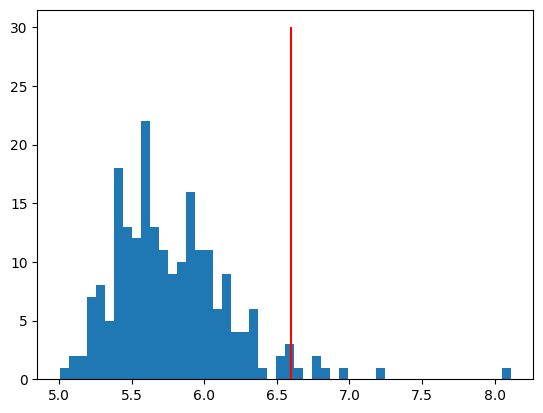

In [17]:
best_threshold = np.mean(y_score) + 2 * np.std(y_score)

plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

In [19]:
folder_path = Path('/content/transistor/test/bent_lead')

class_labels = []
y_true = []
resnet_features = []
y_score = []

for classes in ['bent_lead','cut_lead','damaged_case','misplaced', 'good']:
    folder_path = Path('/content/transistor/test/{}'.format(classes))

    for pth in tqdm(folder_path.iterdir(),leave=False):

        class_label = pth.parts[-2]
        with torch.no_grad():
            test_image = transform(Image.open(pth)).cuda().unsqueeze(0)
            features = model(test_image).squeeze()
            dist,_=torch.sort(torch.norm(memory_bank - features[selected_indices], dim=1))#[-10:].mean()
            dist = dist[:k].mean()
            y_score.append(dist.cpu().numpy())

        class_labels.append(class_label)
        y_true.append(0 if class_label == 'good' else 1)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

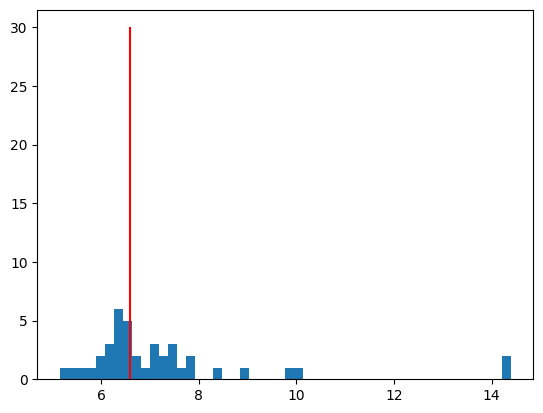

In [20]:
y_score_nok = [score  for score,true in zip(y_score,y_true) if true==1]
plt.hist(y_score_nok,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

## Evaluation matrix

AUC-ROC Score: 0.8445833333333334


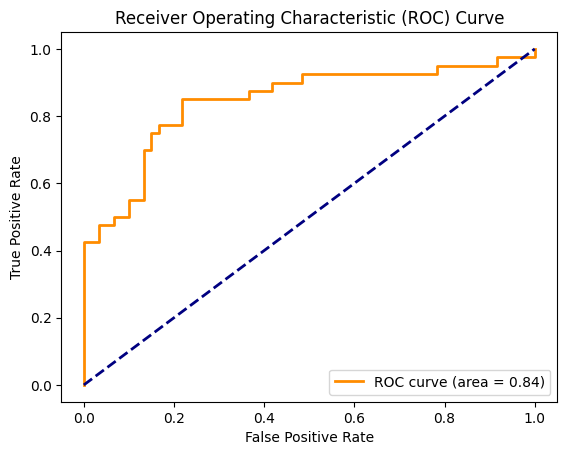

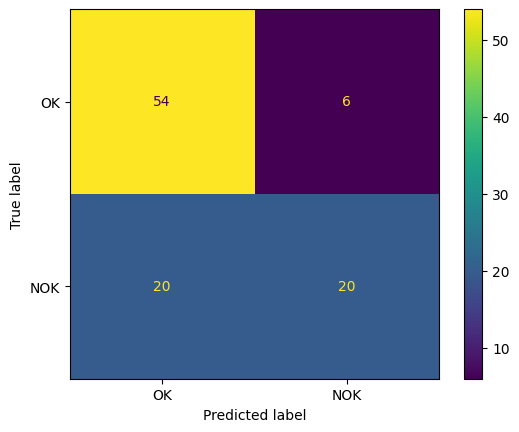

In [21]:
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()